<b><font size="6">AdaBoost Algorithm</font><a class="anchor"><a id='toc'></a></b><br>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [5]:
# IMPORT AND CLEANUP DATA
#import data
techscape = pd.read_csv('train.csv')

# transform Date column into datetime type and then as float
techscape.Date = pd.to_datetime(techscape.Date).values.astype(float)

# transforming non-numerical variables into numerical, so that they can be parsed into the model
enc = LabelEncoder()
# turning OS
enc.fit(techscape['OS'])
techscape['OSn'] = enc.transform(techscape['OS'])
# turning country
enc.fit(techscape['Country'])
techscape['CountryN'] = enc.transform(techscape['Country'])
# turning type of visitor
enc.fit(techscape['Type_of_Visitor'])
techscape['Type_of_VisitorN'] = enc.transform(techscape['Type_of_Visitor'])

# drop non numerical columns
techscape = techscape.drop(['OS', 'Country', 'Type_of_Visitor'], axis=1)

# set access_id as index
techscape = techscape.set_index('Access_ID')

techscape.head()

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,Type_of_Traffic,Buy,OSn,CountryN,Type_of_VisitorN
Access_ID,,,,,,,,,,,,,,,,
102863333,1.584749e+18,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,2,1,0,3,5,2
103117814,1.589933e+18,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,2,6,0,6,1,2
103201891,1.607040e+18,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,4,1,0,6,3,2
103226087,1.608595e+18,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,2,2,1,6,8,2
103234445,1.606176e+18,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,2,3,1,6,6,2


In [6]:
# SCALE DATA

scaler = MinMaxScaler()
techscapeScaled = scaler.fit_transform(techscape)
techscapeScaled = pd.DataFrame(techscapeScaled)

techscapeScaled.columns = techscape.columns
techscapeScaled

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,Type_of_Traffic,Buy,OSn,CountryN,Type_of_VisitorN
0,0.146707,0.000000,0.000000,0.000000,0.00000,0.004255,0.001000,0.0000,0.3335,0.000000,0.083333,0.000000,0.0,0.428571,0.625,1.0
1,0.326347,0.000000,0.000000,0.000000,0.00000,0.032624,0.010700,0.1085,0.2245,0.000000,0.083333,0.357143,0.0,0.857143,0.125,1.0
2,0.919162,0.000000,0.000000,0.000000,0.00000,0.011348,0.001485,0.1250,0.2915,0.000000,0.250000,0.000000,0.0,0.857143,0.375,1.0
3,0.973054,0.000000,0.000000,0.000000,0.00000,0.012766,0.009516,0.0000,0.1250,0.117266,0.083333,0.071429,1.0,0.857143,1.000,1.0
4,0.889222,0.000000,0.000000,0.083333,0.15141,0.051064,0.025166,0.0000,0.0465,0.034562,0.083333,0.142857,1.0,0.857143,0.750,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.290419,0.111111,0.046782,0.083333,0.02177,0.032624,0.017197,0.0000,0.0555,0.000000,0.083333,0.928571,0.0,0.428571,0.000,1.0
9995,0.500000,0.222222,0.051519,0.000000,0.00000,0.004255,0.000431,0.0000,0.0555,0.000000,0.750000,0.285714,0.0,0.857143,0.750,0.0
9996,0.152695,0.000000,0.000000,0.000000,0.00000,0.038298,0.010067,0.0385,0.2595,0.000000,0.083333,0.142857,0.0,0.428571,0.125,1.0
9997,0.314371,0.000000,0.000000,0.000000,0.00000,0.075177,0.011184,0.1130,0.1815,0.000000,0.083333,0.142857,0.0,0.857143,0.375,1.0


In [7]:
X = techscapeScaled.drop(['Buy'],axis=1)
y = techscapeScaled['Buy']

In [8]:
ada = AdaBoostClassifier(random_state= 15, base_estimator= DecisionTreeClassifier(max_depth=2), n_estimators=20, learning_rate=0.9, algorithm='SAMME')

In [9]:
ada.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.9, n_estimators=20, random_state=15)

In [10]:
# importing test data and cleanup

test_data = pd.read_csv('test.csv')

# cleanup dataset
# transforming Date column into datetime type and then as float
test_data.Date = pd.to_datetime(test_data.Date).values.astype(float)

# transforming non-numerical variables into numerical,  so that they can be parsed into the model
enc = LabelEncoder()
# turning OS
enc.fit(test_data['OS'])
test_data['OSn'] = enc.transform(test_data['OS'])
# turning country
enc.fit(test_data['Country'])
test_data['CountryN'] = enc.transform(test_data['Country'])
# turning type of visitor
enc.fit(test_data['Type_of_Visitor'])
test_data['Type_of_VisitorN'] = enc.transform(test_data['Type_of_Visitor'])

#dropping non-numerical columns
test_data = test_data.drop(['OS', 'Country', 'Type_of_Visitor'], axis=1)

# set access_id as index
test_data = test_data.set_index('Access_ID')

# scale data
scaler = MinMaxScaler()
test_data_scaled = scaler.fit_transform(test_data)
test_data_scaled = pd.DataFrame(test_data_scaled)

test_data_scaled.columns = test_data.columns

test_data_scaled.head()

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,Type_of_Traffic,OSn,CountryN,Type_of_VisitorN
0,0.613772,0.000000,0.000000,0.000000,0.0,0.161049,0.288182,0.0695,0.3270,0.000000,0.083333,0.000000,0.857143,0.000,1.0
1,0.341317,0.086957,0.013784,0.000000,0.0,0.102996,0.076765,0.0060,0.0290,0.000000,0.000000,0.214286,0.000000,0.750,1.0
2,0.823353,0.000000,0.000000,0.000000,0.0,0.067416,0.042612,0.0000,0.1250,0.000000,0.416667,0.142857,0.857143,0.750,1.0
3,0.308383,0.000000,0.000000,0.000000,0.0,0.003745,0.037235,0.0000,0.5000,0.000000,0.083333,0.071429,0.857143,0.750,0.0
4,0.832335,0.521739,0.082797,0.083333,0.0,0.241573,0.181962,0.0070,0.0925,0.004004,0.250000,0.642857,0.857143,0.625,1.0


In [11]:
# predictions on test data
y_pred = ada.predict(test_data_scaled)
y_pred.mean()

0.15043478260869564

In [12]:
# add predictions into df
predictions = ada.predict(test_data_scaled)
buy = np.around(predictions,0)
buy = buy.astype(int)

test_data['Buy'] = buy
test_data.reset_index(inplace=True)
test_data

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,Type_of_Traffic,OSn,CountryN,Type_of_VisitorN,Buy
0,798519314,1.598227e+18,0,0.00,0,0.000,86,5332.5478,0.0139,0.0654,0.0000,2,1,6,0,2,0
1,798663101,1.590365e+18,2,37.50,0,0.000,55,1420.4725,0.0012,0.0058,0.0000,1,4,0,6,2,0
2,798663221,1.604275e+18,0,0.00,0,0.000,36,788.5000,0.0000,0.0250,0.0000,6,3,6,6,2,0
3,798760918,1.589414e+18,0,0.00,0,0.000,2,689.0000,0.0000,0.1000,0.0000,2,2,6,6,0,0
4,798856982,1.604534e+18,12,225.25,1,0.000,129,3367.0413,0.0014,0.0185,1.0353,4,10,6,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,962042726,1.606435e+18,10,720.50,2,88.725,220,10580.3448,0.0048,0.0221,0.0000,2,1,6,5,2,0
2296,962063064,1.584662e+18,0,0.00,0,0.000,3,55.0000,0.0667,0.1000,0.0000,2,3,3,6,2,0
2297,962147749,1.606003e+18,2,45.50,0,0.000,22,535.0000,0.0000,0.0250,9.6503,2,11,6,6,2,1
2298,962182167,1.605744e+18,8,166.70,0,0.000,9,171.7000,0.0167,0.0500,0.0000,2,3,6,5,2,0


In [13]:
# sanity check
test_data.Buy.unique()

array([0, 1])

In [14]:
# exporting prediction results
submission = test_data.copy()
submission = submission[['Access_ID', 'Buy']]
submission.to_csv('ada_v1.csv', index=False)

TESTING PARAMETERS FOR ADA

In [15]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [16]:
# defining function to return f1 score of each test
def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
    return n_scores

In [17]:
# defining function to return results and plots of each parameter test scores
def return_results(models):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels = names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

>1 0.609 (0.028)
>2 0.630 (0.027)
>3 0.604 (0.033)
>4 0.575 (0.033)
>5 0.558 (0.033)
>6 0.559 (0.033)
>7 0.581 (0.040)
>8 0.586 (0.029)
>9 0.585 (0.031)
>10 0.590 (0.033)
>11 0.597 (0.032)
>12 0.589 (0.035)


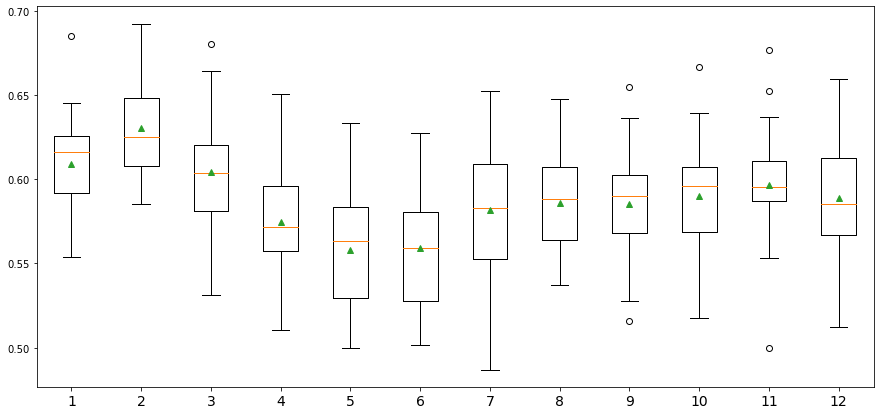

In [18]:
# checking max depth on a decision tree
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=value), random_state = 15)      
    return models

models = get_models([1,2,3,4,5,6,7,8,9,10,11,12])
return_results(models)

In [ ]:
# checking max depth value on a random forest
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = AdaBoostClassifier(base_estimator = RandomForestClassifier(max_depth=value), random_state = 15)      
    return models

models = get_models([1,2,3,4,5,6,7,8,9,10,11,12])
return_results(models)

>ad_LR 0.000 (0.000)
>ad_def nan (nan)
>ad_rf nan (nan)


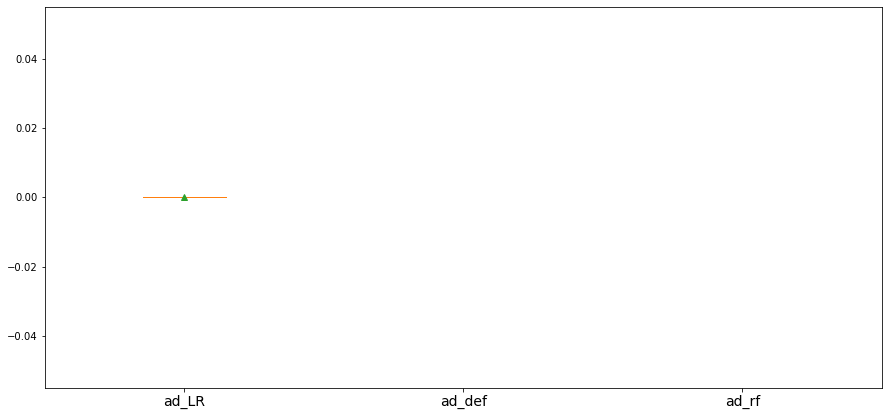

In [20]:
# checking types of estimators
def get_models():
    models = dict()
    models['ad_LR'] = AdaBoostClassifier(base_estimator = LogisticRegression(max_iter=500), random_state = 15)  
    models['ad_def'] = AdaBoostClassifier(base_estimator = DecisionTreeClassifier, random_state = 15)  
    models['ad_rf'] = AdaBoostClassifier(base_estimator = RandomForestClassifier, random_state = 15)
    return models

models = get_models()
return_results(models)

>2 0.537 (0.029)
>5 0.607 (0.026)
>10 0.605 (0.029)
>20 0.616 (0.030)
>30 0.612 (0.030)
>50 0.609 (0.028)
>100 0.609 (0.031)
>150 0.605 (0.031)


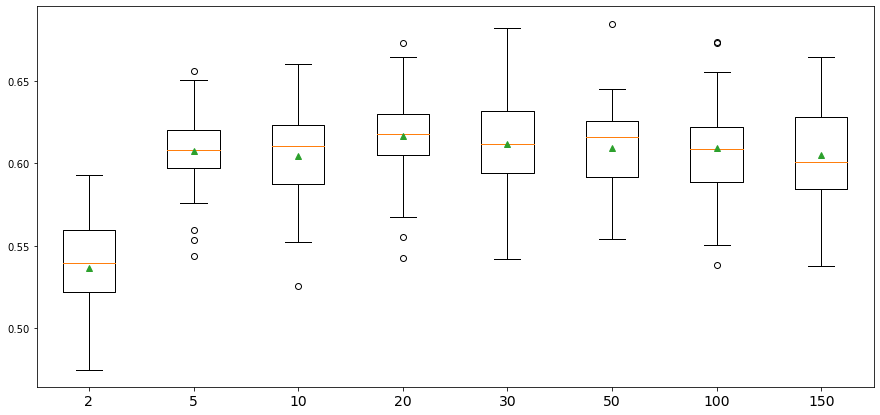

In [21]:
# checking number of estimators
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = AdaBoostClassifier(n_estimators = value, random_state = 15)      
    return models

models = get_models([2,5,10,20,30,50,100,150])
return_results(models)

In [ ]:
# checking with Random Forest but had to force-stop and give up on this test as it was taking many hours
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = AdaBoostClassifier(base_estimator = RandomForestClassifier(max_depth=3), random_state = 15)      
    return models

models = get_models([2,5,10,20,30,50,100,150])
return_results(models)

>2 0.649 (0.029)
>5 0.649 (0.029)
>10 0.649 (0.029)
>20 0.649 (0.029)
>30 0.649 (0.029)


In [ ]:
# checking learning rate values
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = AdaBoostClassifier(learning_rate = value, random_state = 15)      
    return models

models = get_models([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
return_results(models)

In [ ]:
# checking learning rate values with defined number of estimators from previous step
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = AdaBoostClassifier(learning_rate = value, n_estimators = 20, random_state = 15)      
    return models

models = get_models([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
return_results(models)

In [ ]:
# checking algorithm values
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = AdaBoostClassifier(algorithm = value, random_state = 15)      
    return models

models = get_models(["SAMME","SAMME.R"])
return_results(models)